# Loading and Visualize ECoG Signal Test

Loading in the matlab file for the first patient, first conversation and visualizing the ECOG signal.

In [1]:
import os
import scipy
import matplotlib.pyplot as plt
import numpy as np
import mne

In [2]:
# directory = "/Volumes/hasson/ariel/247/conversation_space/crude-conversations/Podcast/NY661_111_Part1_conversation1/preprocessed_all/NY661_111_Part1_conversation1_electrode_preprocess_file_1.mat"
#preprocessed_directory = "/Volumes/hasson/ariel/247/conversation_space/crude-conversations/Podcast/NY717_111_Part1_conversation1/preprocessed_all/NY717_111_Part1_conversation1_electrode_preprocess_file_10.mat"
directory = "/Volumes/hasson/ariel/247/conversation_space/crude-conversations/Podcast/NY717_111_Part1_conversation1/raw/NY717_111_Part1_conversation1_electrode_raw_file_10.mat"
mat = scipy.io.loadmat(directory)
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Nov 25 17:33:34 2019',
 '__version__': '1.0',
 '__globals__': [],
 'electrode_data': array([[-54.63067063, -54.09898528, -54.36482795, ...,  31.23651484,
          42.40190738,  54.89651331]])}

In [3]:
# ecog_signal = mat['p1st']  # for preprocessed
ecog_signal = mat['electrode_data'].ravel()  # for raw
ecog_signal

array([-54.63067063, -54.09898528, -54.36482795, ...,  31.23651484,
        42.40190738,  54.89651331])

In [4]:
ecog_signal.shape

(921601,)

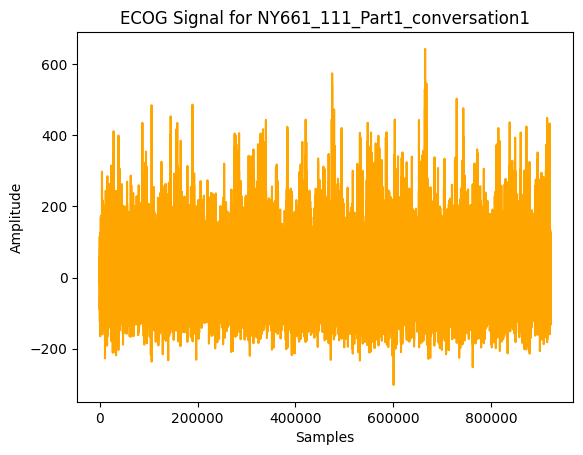

In [5]:
plt.plot(ecog_signal, color='orange')
plt.title('ECOG Signal for NY661_111_Part1_conversation1')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

In [7]:
# create mne raw object using np array
sfreq = 512
info = mne.create_info(ch_names=['ECoG'],sfreq=sfreq, ch_types=['ecog'])
raw = mne.io.RawArray(ecog_signal.reshape(1, -1), info)

Creating RawArray with float64 data, n_channels=1, n_times=921601
    Range : 0 ... 921600 =      0.000 ...  1800.000 secs
Ready.


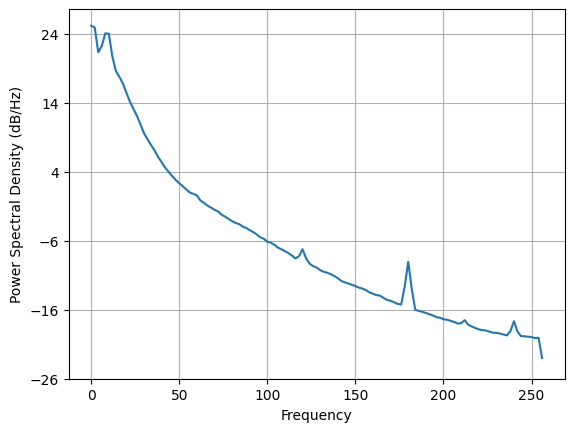

In [8]:
plt.psd(ecog_signal, Fs=raw.info['sfreq'])
plt.show()

## Downsample

In [9]:
new_sfreq = 400
raw_resampled = raw.copy().resample(new_sfreq)

In [10]:
len(raw_resampled) / new_sfreq

1800.0025

In [11]:
len(raw) / 512

1800.001953125

In [12]:
ecog_data = raw_resampled.get_data()
ecog_data.shape

(1, 720001)

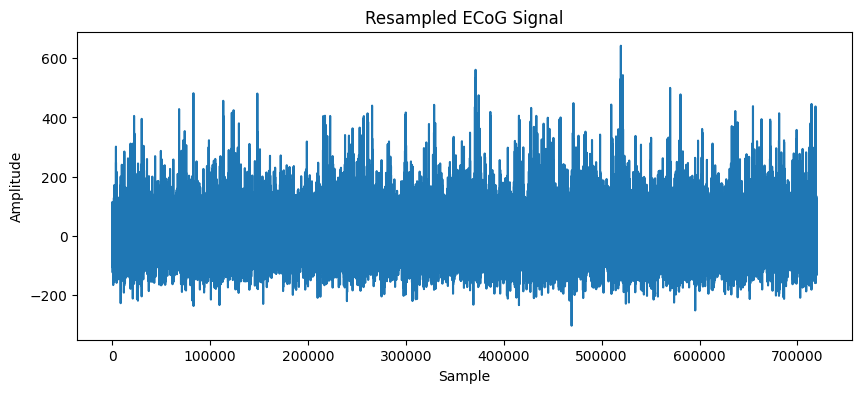

In [13]:
# target_samples = 60000
# current_samples = ecog_signal.shape[0]
# downsample_factor = current_samples // target_samples
# ecog_signal_resampled = scipy.signal.resample(ecog_signal, target_samples)

# plot resampled signal
plt.figure(figsize=(10, 4))
plt.plot(ecog_data.ravel())
plt.title('Resampled ECoG Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

# Power spectrum 

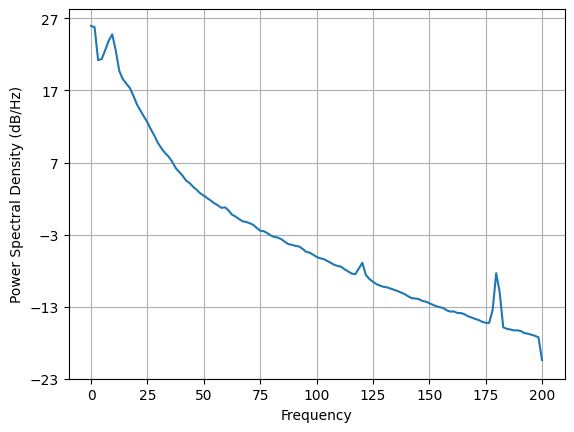

In [14]:
Pxx, freqs = plt.psd(ecog_data.ravel(), Fs=raw_resampled.info['sfreq'])
plt.show()

# Filtering

1. notch filter line noise
2. plot PSD again to see they are removed
3. filter to high-gamma band (broadband) from 64-200 Hz

In [68]:
raw_resampled

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,1 ECoG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,400.00 Hz
Highpass,0.00 Hz
Lowpass,200.00 Hz


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 2641 samples (6.603 s)



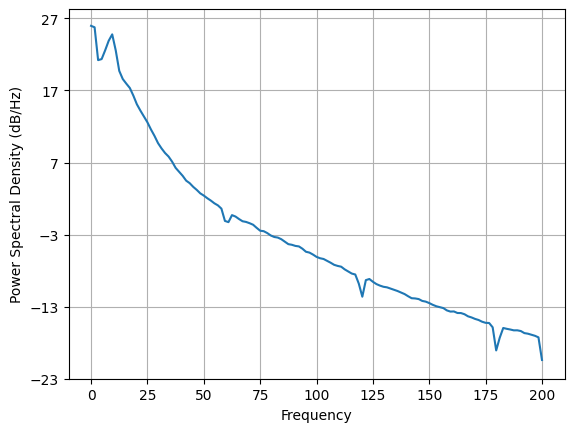

In [16]:
freqs = [60,120,180]

ecog_no_noise = raw_resampled.notch_filter(freqs)
Pxx, freqs = plt.psd(ecog_no_noise.get_data().ravel(), Fs=raw_resampled.info['sfreq']) 
#ravel works like squeeze, doesn't make copy
plt.show()

In [17]:
ecog_no_noise.get_data().shape

(1, 720001)

In [18]:
# extract high gammas (64-200)
ecog_filtered = ecog_no_noise.filter(l_freq=64, 
                                     h_freq=199, 
                                     method='iir')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 64 - 2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 64.00, 199.00 Hz: -6.02, -6.02 dB



In [78]:
ecog_filtered.info['sfreq']

400.0

In [79]:
raw_resampled.info['sfreq']

400.0

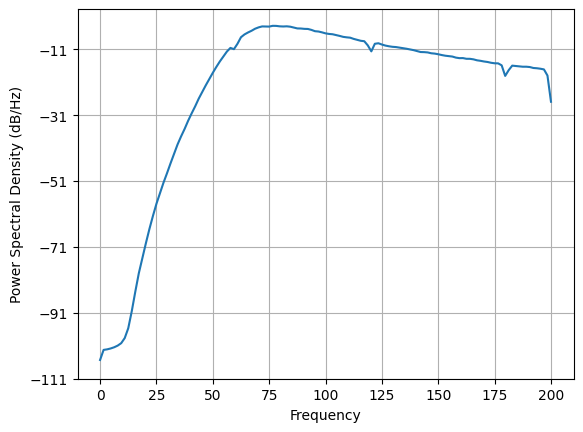

In [19]:
Pxx, freqs = plt.psd(ecog_filtered.get_data().ravel(), Fs=raw_resampled.info['sfreq']) 
plt.show()

In [20]:
ecog_filtered.get_data().shape

(1, 720001)

In [21]:
720001 / 400

1800.0025

## Next Steps

- [x] Slice 2 mins from the signal. How many samples = 2 mins?
- [x] 48,000 samples = 2 mins
- [x] Once have 2 min array, np.array_split(6) gives 6 20 sec arrays
- [x] Compute ACF (np.corr) for each of the 6 arrays
- [x] Compute ACW for each 
- [ ] Plot ACW values over time to see how width changes over time 

In [25]:
# slice 2 mins from signal, plot
start_sample = 0
end_sample = 48000
data, times = ecog_filtered[:, start_sample:end_sample]

# create a new Raw object with samples
info = ecog_filtered.info.copy()
new_raw = mne.io.RawArray(data, info)

Creating RawArray with float64 data, n_channels=1, n_times=48000
    Range : 0 ... 47999 =      0.000 ...   119.998 secs
Ready.


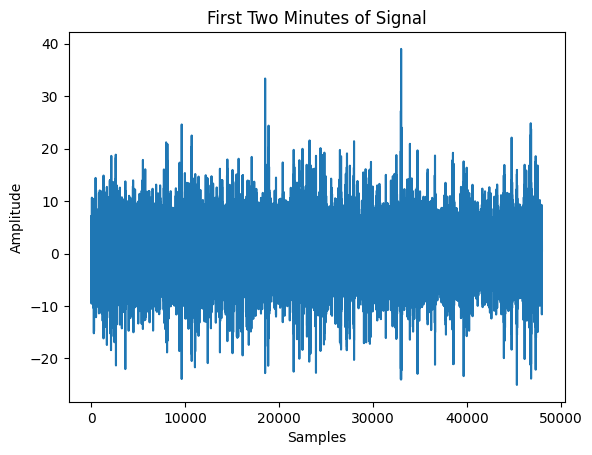

In [31]:
plt.plot(new_raw.get_data().ravel())
plt.title('First Two Minutes of Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

## Reduce Signal Down to Two Minutes

In [35]:
# Array split to 20 secs
split_data = np.array_split(new_raw.get_data().ravel(), 6)
print('Number of arrays:', len(split_data))
split_data

Number of arrays: 6


[array([ 3.20014051e-03,  3.75557971e-01, -1.16419902e+00, ...,
         2.81760966e+00,  9.25524219e+00, -9.03677717e+00]),
 array([-2.70026808e+00, -6.86490321e-01,  8.60288537e+00, ...,
        -3.51971937e+00,  2.94271640e+00, -3.13615332e-04]),
 array([-3.65751711,  3.71310233,  4.66178365, ..., -0.47738274,
        -7.80005776, -2.08240661]),
 array([ 8.09327678,  8.86721865, -8.39462766, ..., -5.49681755,
        -3.51106242,  5.96273615]),
 array([ 1.48717219,  0.14605825, -5.00490904, ..., -5.13619453,
         3.49958757,  4.78088502]),
 array([ 0.5962126 , -3.61150198, -2.07770648, ...,  4.79324604,
         2.41294704,  0.58649227])]

In [48]:
len(split_data)

6

In [92]:
from scipy.signal import correlate, correlation_lags, convolve, windows

def ac_corr(
    x: np.ndarray,
    y: np.ndarray,
    mode="same",
    method="fft",
    norm=True,
    maxlags=None,
):
    """General function to compute auto correlation using scipy

    This function will center the data and normalize it by default.
    """

    # Center
    x = x - x.mean()
    y = y - y.mean()

    # Correlate
    corr = correlate(x, y, mode=mode, method=method)
    lags = correlation_lags(x.size, y.size, mode=mode)
    
    if norm:
        corr /= np.sqrt(np.dot(x, x) * np.dot(y, y))

    if maxlags is not None:
        middle = (lags == 0).nonzero()[0].item()
        lags = np.arange(-maxlags, maxlags + 1)
        corr = corr[middle - maxlags : middle + maxlags + 1]

    return corr, lags

results = []
time = []
for i in range(len(split_data)):
    chunk = split_data[i]
    res, lag = ac_corr(chunk, chunk)
    results.append(res)
    time.append(lag)

results = np.array(results)
time = np.array(time)
print(results.shape)
print(time.shape)

(6, 8000)
(6, 8000)


In [115]:
time

array([[-4000, -3999, -3998, ...,  3997,  3998,  3999],
       [-4000, -3999, -3998, ...,  3997,  3998,  3999],
       [-4000, -3999, -3998, ...,  3997,  3998,  3999],
       [-4000, -3999, -3998, ...,  3997,  3998,  3999],
       [-4000, -3999, -3998, ...,  3997,  3998,  3999],
       [-4000, -3999, -3998, ...,  3997,  3998,  3999]])

In [108]:
time[0].shape

(8000,)

## Autocorrelation Function

In [168]:
from scipy.signal import correlate, correlation_lags

def auto_corr(
    x: np.ndarray,
    y: np.ndarray,
    mode="same",
    method="fft",
    norm=True,
    maxlags=None
):
    """General function to compute auto correlation using scipy

    This function will center the data and normalize it by default.
    """

    # Center
    x = x - x.mean()
    y = y - y.mean()

    # Correlate
    corr = correlate(x, y, mode=mode, method=method)
    lags = correlation_lags(x.size, y.size, mode=mode)

    if norm:
        corr /= np.sqrt(np.dot(x, x) * np.dot(y, y))

    if maxlags is not None:
        middle = (lags == 0).nonzero()[0].item()
        lags = np.arange(-maxlags, maxlags + 1)
        corr = corr[middle - maxlags : middle + maxlags + 1]

    return corr, lags

In [179]:
data = np.array(split_data) # convert to array

corr_results = []
lag_results = []
for k in range(data.shape[0]):
    sub_array = data[k]
    corr, lags = auto_corr(sub_array,sub_array)
    corr_results.append(corr)
    lag_results.append(lag)

results = np.array(corr_results) # correlations
time = np.array(lag_results) # time lags
results.shape

(6, 8000)

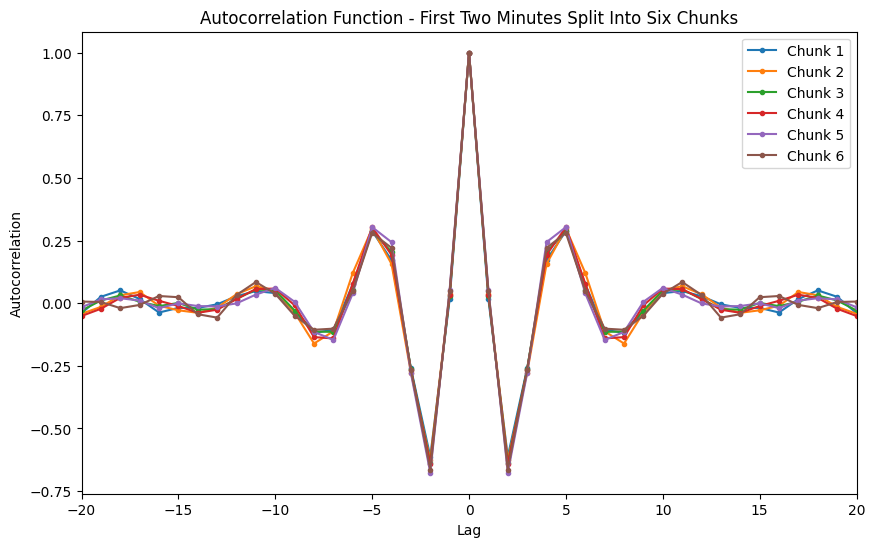

In [183]:
# plot each ACF result

fig, ax = plt.subplots(figsize=(10, 6))
for i in range(results.shape[0]):
    
    ax.plot(time[i], results[i].ravel(), label=f'Chunk {i+1}', marker='.')
    
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_title('Autocorrelation Function - First Two Minutes Split Into Six Chunks (400 Hz)')
ax.legend()
ax.set_xlim(0-20, 0+20)

plt.savefig('ACF_results.svg')
plt.show()

## Autocorrelation Width Function

In [127]:
# Compute ACW using Full Width Half Max

def calculate_half_width(acorr):
    max_value = np.max(acorr)
    half_max_value = max_value / 2.0
    indices_above_half_max = np.where(acorr >= half_max_value)[0]
    if len(indices_above_half_max) > 1:
        width = indices_above_half_max[-1] - indices_above_half_max[0]
    else:
        width = 0
    return width

# Calculate widths for each autocorrelation result
widths = [calculate_half_width(acorr) for acorr in results]

# Assume time points are sequential (1, 2, 3, ..., N)
time_points = np.arange(len(widths))

widths
# # Plot the widths over time
# plt.figure(figsize=(10, 5))
# plt.plot(time_points, widths, marker='o', linestyle='-')
# plt.xlabel('Time')
# plt.ylabel('Autocorrelation Width')
# plt.title('Autocorrelation Widths Over Time')

# plt.show()

[0, 0, 0, 0, 0, 0]

In [135]:
np.where(results[0] >= 0.5)[0]

array([4000])

Since the first two minutes of the ACF widths are the same as of now, there is no change in the ACW over time of 2 minutes.

In [155]:
# Gaussian dist of values for better FWHM plotting of points
from scipy.interpolate import UnivariateSpline

# create spline function
def spline_graph(t, r):
    spline = UnivariateSpline(time[0], results[0]-np.max(results[0])/2, s=0)
    r1, r2 = spline.roots() # find the roots
    return r1, r2

In [156]:
# append ACW of each chunk into array
ACWs = []

for i in range(results.shape[0]):
    r1, r2 = spline_graph(time[i], results[i].ravel())
    diff = r2 - r1
    ACWs.append(diff)

ACWs # convert to array later to plot other chunks over time [once it changes compared to two minutes]

[1.2547961243191241,
 1.2547961243191241,
 1.2547961243191241,
 1.2547961243191241,
 1.2547961243191241,
 1.2547961243191241]

 The ACW for each of the 6 chunks is the same. This is to be expected because each chunk is the same on the plot.
 [Source](https://stackoverflow.com/questions/10582795/finding-the-full-width-half-maximum-of-a-peak) for spline function

## Look at Other Electrodes

In [24]:
#!ls -l /Volumes/hasson/ariel/247/conversation_space/crude-conversations/Podcast/NY717_111_Part1_conversation1/raw

total 1849024
-rw-rw-r--  1 tevaughnshaw  staff  2771145 Nov 25  2019 NY717_111_Part1_conversation1_electrode_raw_file_1.mat
-rw-rw-r--  1 tevaughnshaw  staff  4050087 Nov 25  2019 NY717_111_Part1_conversation1_electrode_raw_file_10.mat
-rw-rw-r--  1 tevaughnshaw  staff  3389646 Nov 25  2019 NY717_111_Part1_conversation1_electrode_raw_file_100.mat
-rw-rw-r--  1 tevaughnshaw  staff  3563590 Nov 25  2019 NY717_111_Part1_conversation1_electrode_raw_file_101.mat
-rw-rw-r--  1 tevaughnshaw  staff  3731980 Nov 25  2019 NY717_111_Part1_conversation1_electrode_raw_file_102.mat
-rw-rw-r--  1 tevaughnshaw  staff  3733803 Nov 25  2019 NY717_111_Part1_conversation1_electrode_raw_file_103.mat
-rw-rw-r--  1 tevaughnshaw  staff  3937285 Nov 25  2019 NY717_111_Part1_conversation1_electrode_raw_file_104.mat
-rw-rw-r--  1 tevaughnshaw  staff  3796792 Nov 25  2019 NY717_111_Part1_conversation1_electrode_raw_file_105.mat
-rw-rw-r--  1 tevaughnshaw  staff  4008572 Nov 25  2019 NY717_111_Part1_conversation1

## Look at Other Patients

In [ ]:
# Autocorrelate 